In [32]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

Read data & convert data type:

In [2]:
df_all = pd.read_csv("combined_data.csv")

In [3]:
df_all["order_purchase_timestamp"] = pd.to_datetime(df_all["order_purchase_timestamp"])
df_all["order_approved_at"] = pd.to_datetime(df_all["order_approved_at"])
df_all["order_delivered_carrier_date"] = pd.to_datetime(df_all["order_delivered_carrier_date"])
df_all["order_delivered_customer_date"] = pd.to_datetime(df_all["order_delivered_customer_date"])
df_all["order_estimated_delivery_date"] = pd.to_datetime(df_all["order_estimated_delivery_date"])

# Behavioral segmentation: RFM model
- Recency — number of days since the last purchase
- Frequency — number of transactions made over a given period
- Monetary — amount spent over a given period of time

## 1. Manually assign labels based on distribution
Create a snapshot date for calculating recency

In [4]:
snapshot_date = df_all['order_purchase_timestamp'].max() + timedelta(days=1)
print(snapshot_date)

2018-08-31 15:11:58


In [5]:
data_process = df_all.groupby(['customer_unique_id']).agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'count',
    'payment_value': 'sum'})

In [6]:
data_process.rename(columns={'order_purchase_timestamp': 'Recency',
                             'order_id': 'Frequency',
                             'payment_value': 'Monetary'}, inplace=True)
data_process

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19
0000f46a3911fa3c0805444483337064,538,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62
0004aac84e0df4da2b147fca70cf8255,289,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,448,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58
ffff371b4d645b6ecea244b27531430a,569,1,112.46


In [68]:
fig = px.histogram(data_process, x="Recency",
                   title='Recency')
#fig.show()
#fig.show(renderer="png")

In [69]:
fig = px.histogram(data_process, x="Frequency",
                   title='Frequency')
#fig.show()
#fig.show(renderer="png")

In [9]:
data_process.groupby(["Frequency"]).count()

,Recency,Monetary
Frequency,,
1,92798,92798
2,2728,2728
3,198,198
4,30,30
5,8,8
6,6,6
7,3,3
9,1,1
17,1,1


In [70]:
fig = px.histogram(data_process, x="Monetary",
                   title='Monetary')
#fig.show()
#fig.show(renderer="png")

### Calculate R and F groups

#### Recency: 5 labels for 5 equal percentile groups

5 is the highest recency, 1 is lowest

In [11]:
r_labels = range(5, 0, -1)
r_groups = pd.qcut(data_process['Recency'], [0, 0.2, 0.4, 0.6, 0.8, 1], labels=r_labels)
data_process = data_process.assign(R = r_groups.values)

#### Frequency: 3 groups, not evenly distributed

- 1: just once
- 2: 2-6 times
- 3: more than 7 times

In [12]:
data_process['F'] = 1
data_process.loc[(data_process['Frequency'] >= 2) & (data_process['Frequency'] < 7), 'F'] = 2
data_process.loc[data_process['Frequency'] >= 7, 'F'] = 3

#### Monetary: 5 labels for 5 equal percentile groups

1 is lowest spending, 5 is highest

In [13]:
m_labels = range(1, 6)
m_groups = pd.qcut(data_process['Monetary'], [0, 0.2, 0.4, 0.6, 0.8, 1], labels=m_labels)
data_process = data_process.assign(M = m_groups.values)

In [14]:
def join_rfm(x):
    return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))

data_process['RFM_Segment'] = data_process.apply(join_rfm, axis=1)
rfm = data_process
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,4,1,4,414
0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,4,1,1,411
0000f46a3911fa3c0805444483337064,538,1,86.22,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,289,1,196.89,2,1,4,214


**In theory, the highest score is 5+3+5 = 13, the lowest score is 1+1+1 = 1**

In [71]:
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

### Add segment label and actions

In [16]:
def rfm_level(df):
    if df['RFM_Score'] >= 11:
        return 'VIP - Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 9) and (df['RFM_Score'] < 11)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Potential Loyalist'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 8)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 6)):
        return 'Needs Attention'
    else:
        return 'Hibernating - Almost Lost'

rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
rfm

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,4,1,4,414,9,Champions
0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,4,1,1,411,6,Promising
0000f46a3911fa3c0805444483337064,538,1,86.22,1,1,2,112,4,Needs Attention
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,2,1,1,211,4,Needs Attention
0004aac84e0df4da2b147fca70cf8255,289,1,196.89,2,1,4,214,7,Promising
...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,448,1,2067.42,1,1,5,115,7,Promising
fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58,3,1,2,312,6,Promising
ffff371b4d645b6ecea244b27531430a,569,1,112.46,1,1,3,113,5,Needs Attention


In [17]:
def rfm_action(df):
    if df['RFM_Score'] >= 11:
        return 'Exclusive offer & referral program'
    elif ((df['RFM_Score'] >= 9) and (df['RFM_Score'] < 11)):
        return 'Upsell & Cross-sell'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Cross-sell & price incentives'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 8)):
        return 'Price incentives & limited time offer'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 6)):
        return 'Aggressive price incentives'
    else:
        return 'No need to re-acquire'

rfm['RFM_Action'] = rfm.apply(rfm_action, axis=1)
rfm

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,RFM_Action
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,4,1,4,414,9,Champions,Upsell & Cross-sell
0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,4,1,1,411,6,Promising,Price incentives & limited time offer
0000f46a3911fa3c0805444483337064,538,1,86.22,1,1,2,112,4,Needs Attention,Aggressive price incentives
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,2,1,1,211,4,Needs Attention,Aggressive price incentives
0004aac84e0df4da2b147fca70cf8255,289,1,196.89,2,1,4,214,7,Promising,Price incentives & limited time offer
...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,448,1,2067.42,1,1,5,115,7,Promising,Price incentives & limited time offer
fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58,3,1,2,312,6,Promising,Price incentives & limited time offer
ffff371b4d645b6ecea244b27531430a,569,1,112.46,1,1,3,113,5,Needs Attention,Aggressive price incentives


### Visualization

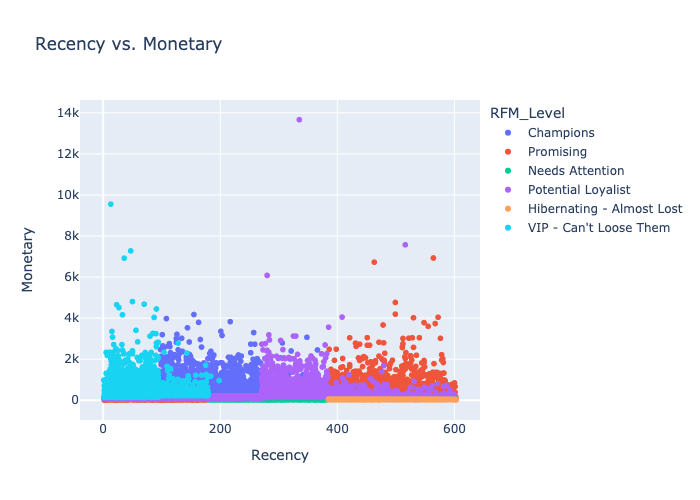

In [65]:
fig = px.scatter(rfm, x="Recency", y="Monetary",
                 color='RFM_Level',
                 hover_data={'RFM_Level':True},
                 title='Recency vs. Monetary')
#fig.show()
fig.show(renderer="png")
#fig.write_html("visuals/Recency vs. Monetary.html")

Calculate average values for each RFM_Level, and return a size of each segment

In [24]:
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(2).reset_index()
# Print the aggregated dataset
rfm_level_agg

RFM_Level Recency Frequency Monetary       
                                mean      mean     mean  count
0                  Champions  121.80      1.06   258.45  19542
1  Hibernating - Almost Lost  475.42      1.00    39.72   3969
2            Needs Attention  359.21      1.00    65.98  19440
3         Potential Loyalist  185.50      1.03   199.93  15321
4                  Promising  258.86      1.01   133.14  33084
5     VIP - Can't Loose Them   55.34      1.25   449.59   4417

In [25]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RFM_Level', 'RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_level_agg

,RFM_Level,RecencyMean,FrequencyMean,MonetaryMean,Count
0,Champions,121.80,1.06,258.45,19542
1,Hibernating - Almost Lost,475.42,1.00,39.72,3969
2,Needs Attention,359.21,1.00,65.98,19440
3,Potential Loyalist,185.50,1.03,199.93,15321
4,Promising,258.86,1.01,133.14,33084
5,VIP - Can't Loose Them,55.34,1.25,449.59,4417


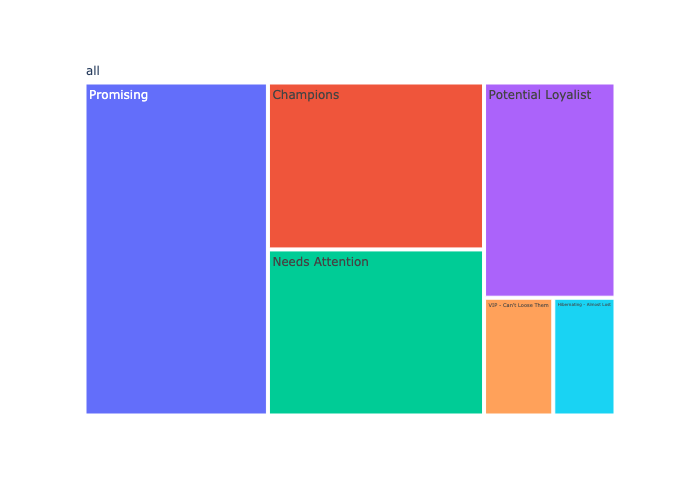

In [66]:
fig = px.treemap(rfm_level_agg, path=[px.Constant("all"), 'RFM_Level'], values='Count')
#fig.show()
fig.show(renderer="png")

## 2. K-means

The goal of K means is to group data points into distinct non-overlapping subgroups. K-Means clustering is unsupervised: no labeled data for this clustering; It performs the division of objects into clusters that share similarities and are dissimilar to the objects belonging to another cluster.

In [27]:
data_rfm = rfm[['Recency', 'Frequency', 'Monetary']]

Recency      1.0
Frequency    1.0
Monetary     0.0
dtype: float64

In [29]:
data_rfm

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19
0000f46a3911fa3c0805444483337064,538,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62
0004aac84e0df4da2b147fca70cf8255,289,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,448,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58
ffff371b4d645b6ecea244b27531430a,569,1,112.46


To find which ‘k’ value is more suitable for our data, we use **the elbow method**:

- Compute K-Means clustering for different values of K by varying K from 1 to 10 clusters.
- For each K, calculate the total within-cluster sum of square (WCSS).
- Plot the curve of WCSS vs the number of clusters K.
- The location of a bend (knee) in the plot is generally considered as an indicator of the appropriate number of clusters.

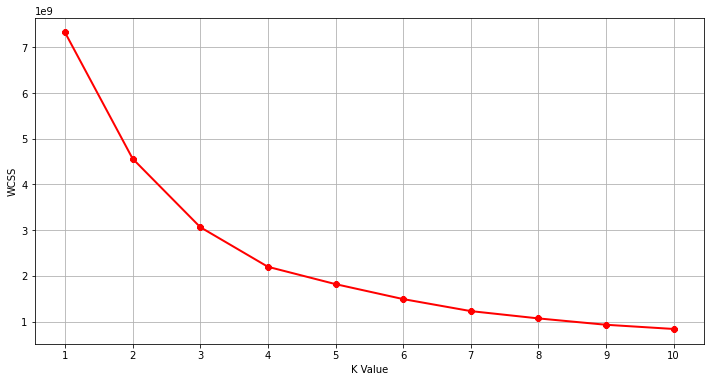

In [33]:
from sklearn.cluster import KMeans

wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(data_rfm)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

In [34]:
kmeans = KMeans(n_clusters = 4) 
kmeans.fit(data_rfm)

cluster_labels = kmeans.labels_
data_rfm_k4 = data_rfm.assign(Cluster = cluster_labels)
grouped = data_rfm_k4.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(2)

Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0        387.05      1.02   121.08  38208
1        128.67      1.03   121.09  50719
2        239.46      1.09  1929.95    718
3        230.75      1.13   618.64   6128

Since the elbow is not clear on the curve, we calculate the **silhouette score**:

- 1: Means clusters are well apart from each other and clearly distinguished.
- 0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.
- -1: Means clusters are assigned in the wrong way.

In [41]:
from sklearn.metrics import silhouette_score
%matplotlib inline

print(f'Silhouette Score(k=4): {silhouette_score(data_rfm, cluster_labels)}')

Silhouette Score(k=4): 0.4564857660559343


In [42]:
kmeans = KMeans(n_clusters = 5) 
kmeans.fit(data_rfm)

cluster_labels = kmeans.labels_
data_rfm_k5 = data_rfm.assign(Cluster = cluster_labels)
grouped = data_rfm_k5.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(2)

Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0        128.75      1.02   107.91  47900
1        232.96      1.10  2487.54    325
2        221.25      1.11   404.02   9660
3        244.84      1.14  1021.71   2070
4        391.25      1.02   110.26  35818

In [43]:
print(f'Silhouette Score(k=5): {silhouette_score(data_rfm, cluster_labels)}')

Silhouette Score(k=5): 0.4605425086496772


In [44]:
kmeans = KMeans(n_clusters = 6) 
kmeans.fit(data_rfm)

cluster_labels = kmeans.labels_
data_rfm_k6 = data_rfm.assign(Cluster = cluster_labels)
grouped = data_rfm_k6.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(2)

Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0         87.26      1.03   113.84  32432
1        232.75      1.08  2609.76    276
2        457.77      1.02   117.79  20776
3        241.45      1.14  1085.74   1842
4        255.65      1.02   105.36  31849
5        222.03      1.12   433.75   8598

In [45]:
print(f'Silhouette Score(k=6): {silhouette_score(data_rfm, cluster_labels)}')

Silhouette Score(k=6): 0.3964436395378976


Therefore, 5 segments would be optimized

In [51]:
data_rfm_k5

,Recency,Frequency,Monetary,Cluster
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,0
0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,0
0000f46a3911fa3c0805444483337064,538,1,86.22,4
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,4
0004aac84e0df4da2b147fca70cf8255,289,1,196.89,4
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,448,1,2067.42,1
fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58,4
ffff371b4d645b6ecea244b27531430a,569,1,112.46,4


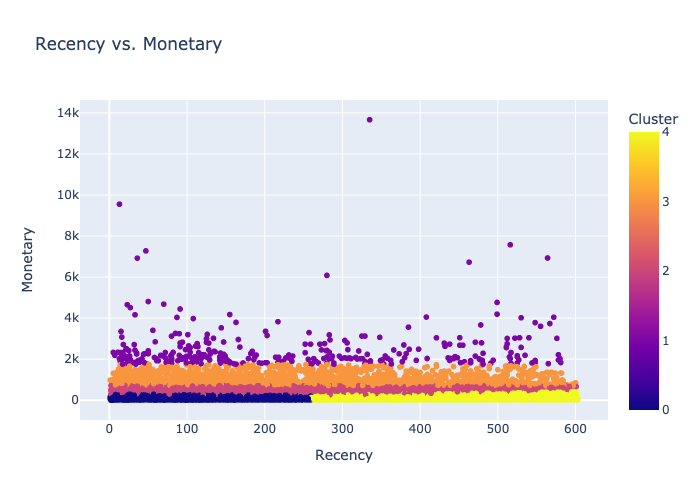

In [72]:
fig = px.scatter(data_rfm_k5, x="Recency", y="Monetary",
                 color='Cluster',
                 hover_data={'Cluster':True},
                 title='Recency vs. Monetary')
#fig.show()
fig.show(renderer="png")

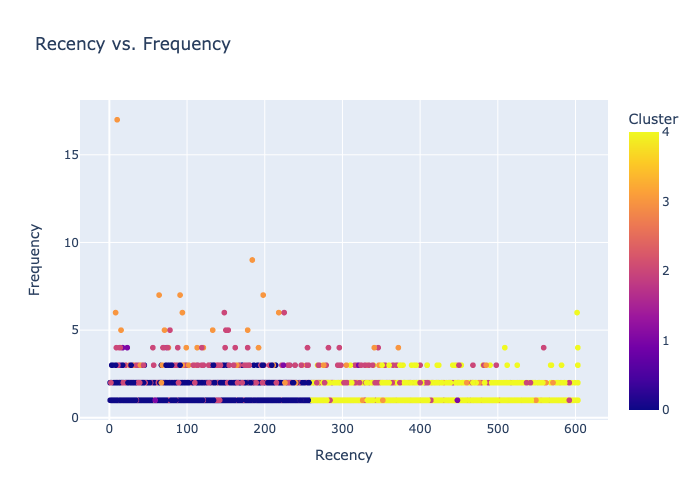

In [73]:
fig = px.scatter(data_rfm_k5, x="Recency", y="Frequency",
                 color='Cluster',
                 hover_data={'Cluster':True},
                 title='Recency vs. Frequency')
#fig.show()
fig.show(renderer="png")

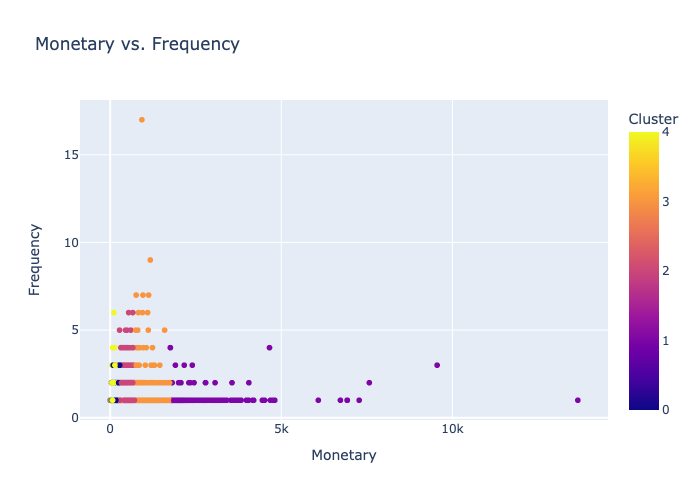

In [74]:
fig = px.scatter(data_rfm_k5, x="Monetary", y="Frequency",
                 color='Cluster',
                 hover_data={'Cluster':True},
                 title='Monetary vs. Frequency')
#fig.show()
fig.show(renderer="png")

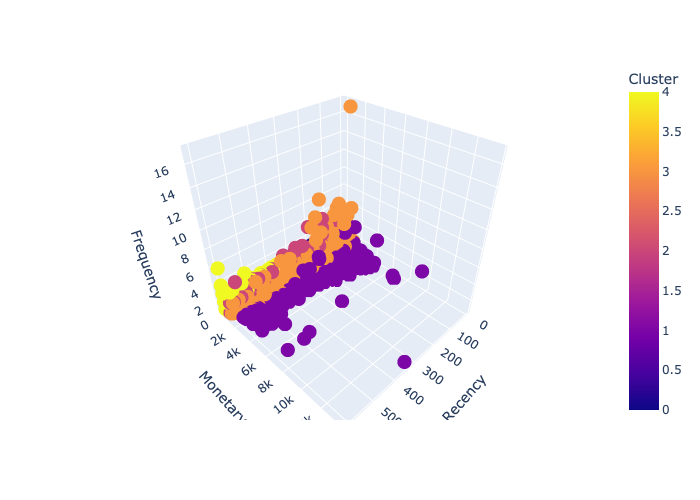

In [76]:
fig = px.scatter_3d(data_rfm_k5, x='Recency', y='Monetary', z='Frequency',
              color='Cluster')
#fig.show()
fig.show(renderer="png")

Based on the distribution pattern above, we can assign labels to each cluster for better description.

In [57]:
def rfm_level(df):
    if df['Cluster'] == 0: #low recency, low monetary, low to mid frequency
        return 'Promising'
    elif (df['Cluster'] == 1): #high monetary
        return 'VIP'
    elif (df['Cluster'] == 2): #low to mid monetary
        return 'Potential Loyalist'
    elif (df['Cluster'] == 3): #mid to high monetary
        return 'Champions'
    else: #high recency, low monetary, low to mid frequency
        return 'Hibernating - Almost Lost'

data_rfm_k5['RFM_Level'] = data_rfm_k5.apply(rfm_level, axis=1)
data_rfm_k5

,Recency,Frequency,Monetary,Cluster,RFM_Level
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,0,Promising
0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,0,Promising
0000f46a3911fa3c0805444483337064,538,1,86.22,4,Hibernating - Almost Lost
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,4,Hibernating - Almost Lost
0004aac84e0df4da2b147fca70cf8255,289,1,196.89,4,Hibernating - Almost Lost
...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,448,1,2067.42,1,VIP
fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58,4,Hibernating - Almost Lost
ffff371b4d645b6ecea244b27531430a,569,1,112.46,4,Hibernating - Almost Lost


In [60]:
rfm_group = data_rfm_k5.groupby('RFM_Level')['Cluster'].count().round(2).reset_index()
rfm_group

,RFM_Level,Cluster
0,Champions,2070
1,Hibernating - Almost Lost,35818
2,Potential Loyalist,9660
3,Promising,47900
4,VIP,325


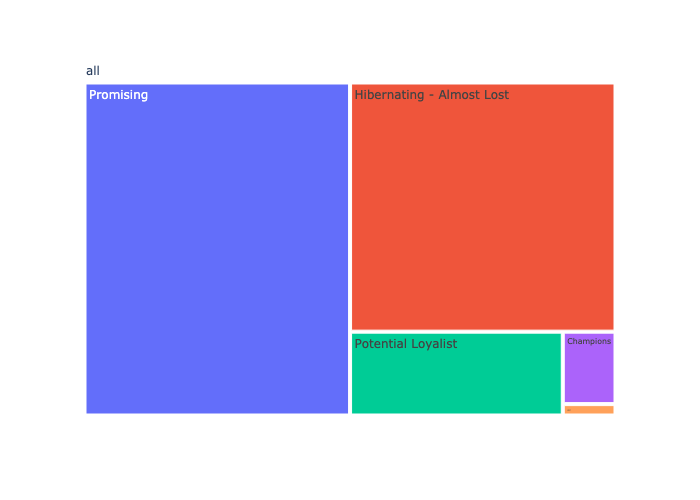

In [67]:
fig = px.treemap(rfm_group, path=[px.Constant("all"), 'RFM_Level'], values='Cluster')
#fig.show()
fig.show(renderer="png")